# Pipeline visualization

Sometime it is useful to visualise the pipeline built with pyWATTS. Examples could be:
* you want to explain the pipeline structure to your collegues
* you want to debug your pipeline to find errors
* you want to figure out how the pipeline of someone else works

Thus, we aim to explain in this notebook, how you can visualise your pipeline.


First you need to import everything.

In [1]:
from pywatts.callbacks import LinePlotCallback
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.core.pipeline import Pipeline
# All modules required for the pipeline are imported
from pywatts.modules import CalendarExtraction, CalendarFeature, ClockShift, LinearInterpolater, SKLearnWrapper, Sampler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from pywatts.summaries import RMSE

Afterwards, we can now build our simple pipeline.

In [2]:
pipeline = Pipeline(path="../results")

# Extract dummy calendar features, using holidays from Germany
# NOTE: CalendarExtraction can't return multiple features.
calendar = CalendarExtraction(continent="Europe", country="Germany", features=[CalendarFeature.month,
                                                                               CalendarFeature.weekday,
                                                                               CalendarFeature.weekend]
                              )(x=pipeline["load_power_statistics"])

# Deal with missing values through linear interpolation
imputer_power_statistics = LinearInterpolater(
    method="nearest", dim="time", name="imputer_power"
)(x=pipeline["load_power_statistics"])

# Scale the data using a standard SKLearn scaler
power_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_power")
scale_power_statistics = power_scaler(x=imputer_power_statistics)

# Create lagged time series to later be used as regressors
shift_power_statistics = ClockShift(lag=1, name="ClockShift_Lag1"
                                    )(x=scale_power_statistics)
shift_power_statistics2 = ClockShift(lag=2, name="ClockShift_Lag2"
                                     )(x=scale_power_statistics)
scaler_target = SKLearnWrapper(module=StandardScaler(), name="scaler_power")
scaled_target = scaler_target(x=imputer_power_statistics)
target_multiple_output = Sampler(24, name="sampled_data")(x=scaled_target)

# Select features based on F-statistic
selected_features = SKLearnWrapper(
    module=SelectKBest(score_func=f_regression, k=2)
)(
    power_lag1=shift_power_statistics,
    power_lag2=shift_power_statistics2,
    calendar=calendar,
    target=scale_power_statistics,
)

# Create a linear regression that uses the lagged values to predict the current value
# NOTE: SKLearnWrapper has to collect all **kwargs itself and fit it against target.
#       It is also possible to implement a join/collect class
regressor_power_statistics = SKLearnWrapper(
    module=LinearRegression(fit_intercept=True)
)(
    features=selected_features,
    target=target_multiple_output,
    callbacks=[LinePlotCallback("linear_regression")],
)

# Rescale the predictions to be on the original time scale
inverse_power_scale = scaler_target(
    x=regressor_power_statistics, computation_mode=ComputationMode.Transform,
    method="inverse_transform", callbacks=[LinePlotCallback("rescale")]
)

# Calculate the root mean squared error (RMSE) between the linear regression and the true values
# save it as csv file
rmse = RMSE()(y_hat=inverse_power_scale, y=target_multiple_output)


c:\users\bi4372\pycharmprojects\pywatts\pywatts\modules\preprocessing\clock_shift.py:31: UserWarning: The ClockShift is deprecated. Please use the select module with for example Select(start=-23) for selecting the value 23 ago for for each step. It will be removed in version 0.5.
  warnings.warn(
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:209: UserWarning: The step with name scaler_power is renamed to scaler_power_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")
c:\users\bi4372\pycharmprojects\pywatts\pywatts\modules\preprocessing\sampler.py:31: UserWarning: The sampler is deprecated. Please use the select module with for example Select(start=-23, stop=0, step=1) for selecting the past 24 values for each step. It will be removed in version 0.5.
  warnings.warn(
C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:209: UserWarni

Now, we can call the draw method of the pipeline. This method returns us a Drawing object from the schemdraw library. If we call draw on this object, we can visualise the pipeline directly. If you aim to save the pipeline you can instead call save on the drawing object.
The meaning of the boxes are:

* Shifted box represesnt input data
* Rectangles represent steps
* Round Boxes represent Summaries
* ...

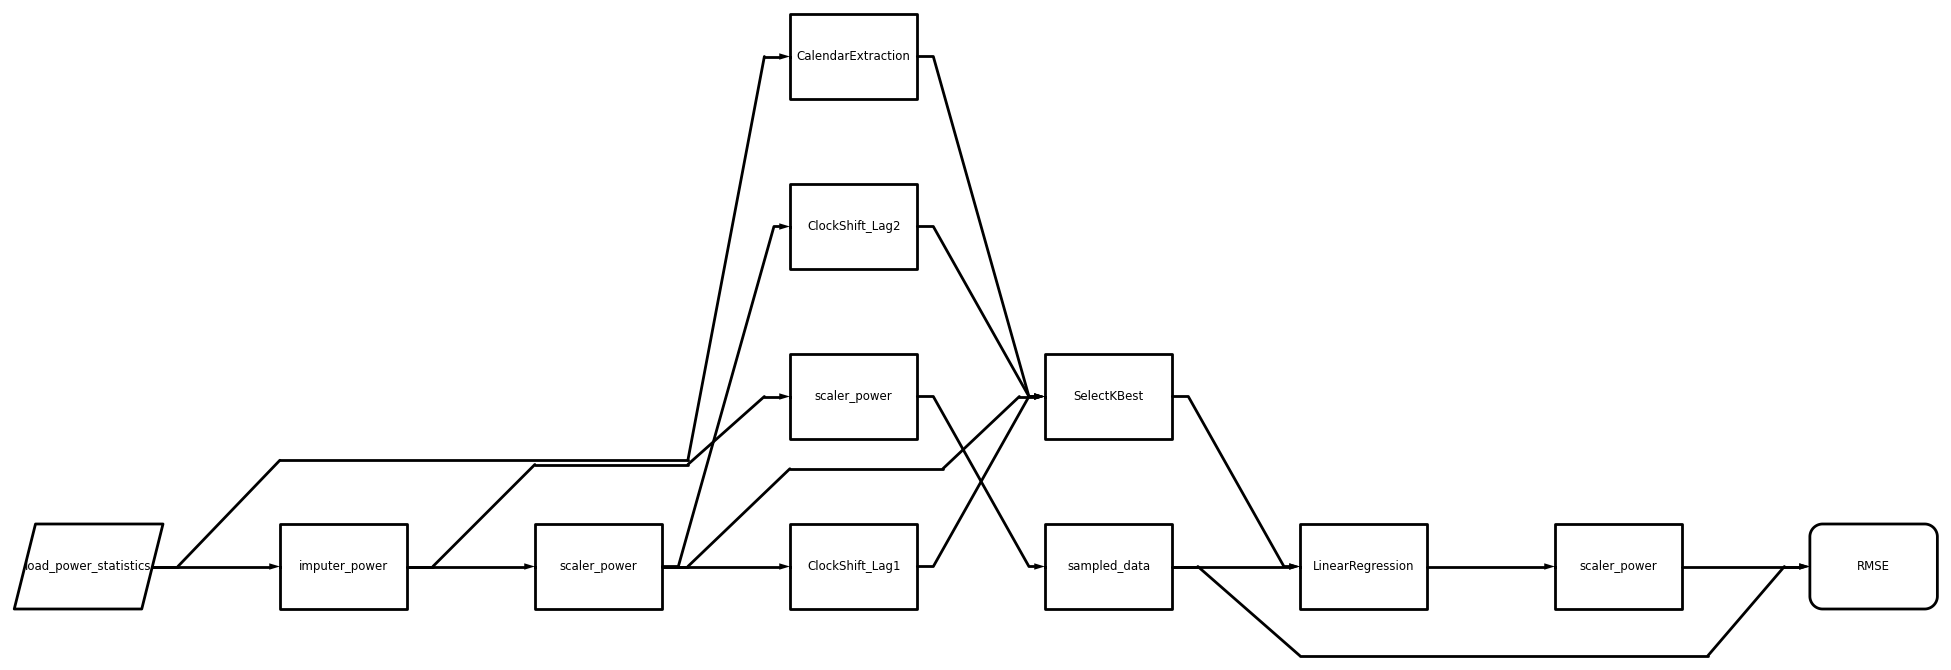

In [3]:
drawing = pipeline.draw()
drawing.draw()

## Other complex pipeline

C:\Users\bi4372\PycharmProjects\pywatts-pipeline\pywatts_pipeline\core\transformer\base.py:209: UserWarning: The step with name Regression is renamed to Regression_1 due to naming conflicts.
  warnings.warn(f"The step with name {self.name} is renamed to {name} due to naming conflicts.")


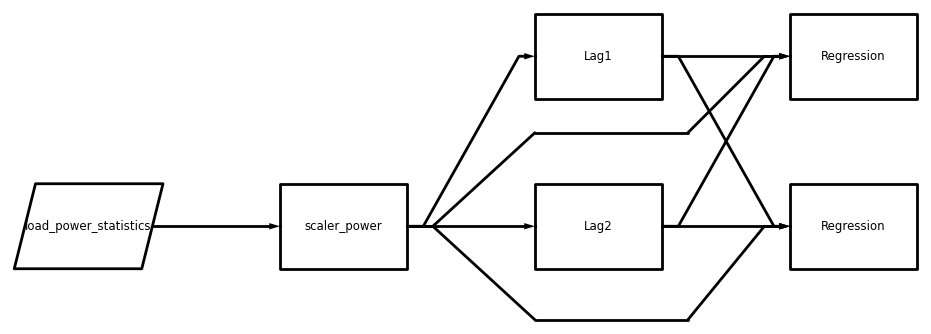

In [4]:
regressor_lin_reg = SKLearnWrapper(module=LinearRegression(fit_intercept=True), name="Regression")
regressor_svr = SKLearnWrapper(module=SVR(), name="Regression")
power_scaler = SKLearnWrapper(module=StandardScaler(), name="scaler_power")

# Build a train pipeline. In this pipeline, each step processes all data at once.
train_pipeline = Pipeline(path="../results/train")

# Create preprocessing pipeline for the preprocessing steps
scale_power_statistics = power_scaler(x=train_pipeline["load_power_statistics"], callbacks=[LinePlotCallback("scaled")])

# Create lagged time series to later be used in the regression
lag1 = ClockShift(lag=1, name="Lag1")(x=scale_power_statistics)
lag2 = ClockShift(lag=2, name="Lag2")(x=scale_power_statistics)

# Addd the regressors to the train pipeline
regressor_lin_reg(Lag1=lag1,
                  Lag2=lag2,
                  target=scale_power_statistics,
                  callbacks=[LinePlotCallback('LinearRegression')])
regressor_svr(Lag1=lag1,
              Lag2=lag2,
              target=scale_power_statistics,
              callbacks=[LinePlotCallback('SVR')])

train_pipeline.draw().draw()

## Information about what happens under the hood.

When drawing non-sequential workflows, we have some requirements that need to be fulfilled.
1. Predessors should be always on the left and succesors should be always on the right. Consequently arrows goes from left to right.
2. Lines should not intersect nodes
3. All inputs of a node has to be identifiable. I.e., edges are only allowed to overlap if they go to the same target.

To fulfil requirement 1, we sort the steps in the workflow accordingly. Compare sorting of DAGs.

To fulfil requirement 2, we use a grid based approach to draw the graph. The rows contain alternately nodes or edges. Similarly, the columns also contain altenately nodes or edges. This ensures that the edges do not intersect the nodes.

To fulfil requirement 3, we draw edges according to the following rules.
* For each row of edges, the level is determined by the id of the starting step. Thus, at each point of the edge the source is unambigious. Therefore, if the edge meets it's target, this is also unambigious. Thus, for each node all inputs are identifiable.

(I hope there are no mistakes in this considerations).

